# *This file allows to generate all plots necessary for figures*

# **Useful packages and functions**

In [1]:
using DifferentialEquations, Plots, Polynomials, LaTeXStrings, ColorSchemes, DelimitedFiles, DataFrames
using Statistics, StatsPlots, Random, ProgressMeter, Printf, LinearAlgebra, Plots.PlotMeasures
include("DA_kinetics.jl") # Loading of DA kinetics of gating variables
include("DA_models.jl") # Loading of DA model
include("DA_utils.jl"); # Loading of some utils functions

# **Global variables**

In [2]:
# Definition of simulation time (in ms)
const Tfinal = 20000
const tspan  = (0.0, Tfinal)
tt = 0. : 0.01 : Tfinal
tt_rand = 0. : 1 : Tfinal
tt_plot = 0. : 0.01 : 20000.

# Definition of reversal potential values (in mV), [Mg] and membrane capacitance
const VNa     = 60. # Sodium reversal potential
const VK      = -90. # Potassium reversal potential
const VCa     = 50. # Calcium reversal potential
const VH      = -29. # H reversal potential
const VLNS    = -65. # Leak reversal potential
const EPacemaker = 4.2732015978991615 # Reversal potential of pacemaking channels

const C       = 1. # Membrane capacitance
const fCa     = 0.018 # Fraction of unbuffered free calcium
const ICapmax = 11 # Maximum calcium pump current
const F       = 96520 # Faraday constant in ms*µA/mmol (and taking cm³=mL)
const d       = 15 # Soma diameter in cm
const L       = 25 # Soma length

# Definition of voltage range for the DICs
const Vmin = -100 
const Vmax = 50
const Vrange = range(Vmin, stop=Vmax, step=0.0154640);

In [3]:
# Modifying backend GR attributes
gr(guidefontsize=25, tickfontsize=15, legendfontsize=12, margin=5Plots.mm, grid=false)
myApple = RGBA(187/255, 206/255, 131/255, 1)
mySalmon = RGBA(243/255, 124/255, 130/255)
myYellow = RGBA(228/255, 205/255, 121/255, 1)
myBlue = RGBA(131/255, 174/255, 218/255, 1)
myDarkBlue = RGBA(114/255, 119/255, 217/255, 1)
myOrange = RGBA(241/255, 175/255, 113/255, 1)
myPink = RGBA(243/255, 124/255, 130/255, 1)
myPurple = RGBA(169/255, 90/255, 179/255, 1)
myGreen = RGBA(132/255, 195/255, 168/255, 1)
myRed = RGBA(158/255, 3/255, 8/255, 1)
myGray = RGBA(150/255, 150/255, 150/255, 1)
myLightBlue = RGBA(127/255, 154/255, 209/255, 1);
default(fmt = :png);

In [4]:
# Define a struct (optional, but useful if you need parameters)
struct NoisyFunction
    amplitude::Float64  # amplitude of the noise
end

# Overload the () operator to make the struct callable
function (nf::NoisyFunction)(x::Float64)
    noise = nf.amplitude * randn()  # Generate Gaussian noise (mean 0, std 1)
    return noise  # Example function with noise
end

function condition(u,t,integrator) # Event when event_f(u,t) == 0
  (u[1]- (-20.))
end

function affect!(integrator)
end

cb = ContinuousCallback(condition, affect!, nothing, save_positions = (true, false));

# Figure supp 1:

In [5]:
import Random
Random.seed!(1234)
g_all_pacemaker = readdlm("./old_data/g_all_pacemaker.dat")
is = randperm(200)[1:10]

10-element Vector{Int64}:
 186
   2
  51
  73
  45
  72
  33
  85
  27
  30

## Map 1

In [6]:
(gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, _) = g_all_pacemaker[is[1], :]

# Screening parameters
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
freqs = zeros(n, n)

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), mPacemaker_inf(V0), Ca0]

freqs = zeros(n, n)

for (i, gPacemaker) in enumerate(gPacemakers)
    display(i)
    for (j, tau) in enumerate(taus)
        # Parameter vector for simulations
        p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker, tau)
        
        # Simulation
        prob = ODEProblem(DA_ODE_true_notinstant, x0, tspan, p) # Describing the problem
        sol_ij = solve(prob, Tsit5(); maxiters=1e9, callback=cb,
                       save_everystep=false,save_start=false,save_end=false)
        
        if length(sol_ij.t) < 10
            freqs[i, j] = NaN
            
            ISIs_ij = Float64[]
            filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
            writedlm(filename, ISIs_ij)
        else
            spike_times = sol_ij.t
            filter!(x -> x ≥ 5000, spike_times)
            
            if length(spike_times) < 2
                freqs[i, j] = NaN
            
                ISIs_ij = Float64[]
                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)
            else
        
                # Extracting ISIs
                ISIs_ij = zeros(length(spike_times)-1)
                for k = 1 : length(spike_times) - 1
                    ISIs_ij[k] = spike_times[k+1] - spike_times[k]
                end

                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)

                freqs[i, j] = 1000/mean(ISIs_ij)
            end
        end
    end
end

writedlm("./data/freqs_degenerate1.dat", freqs);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

In [7]:
freqs = readdlm("./data/freqs_degenerate1.dat");

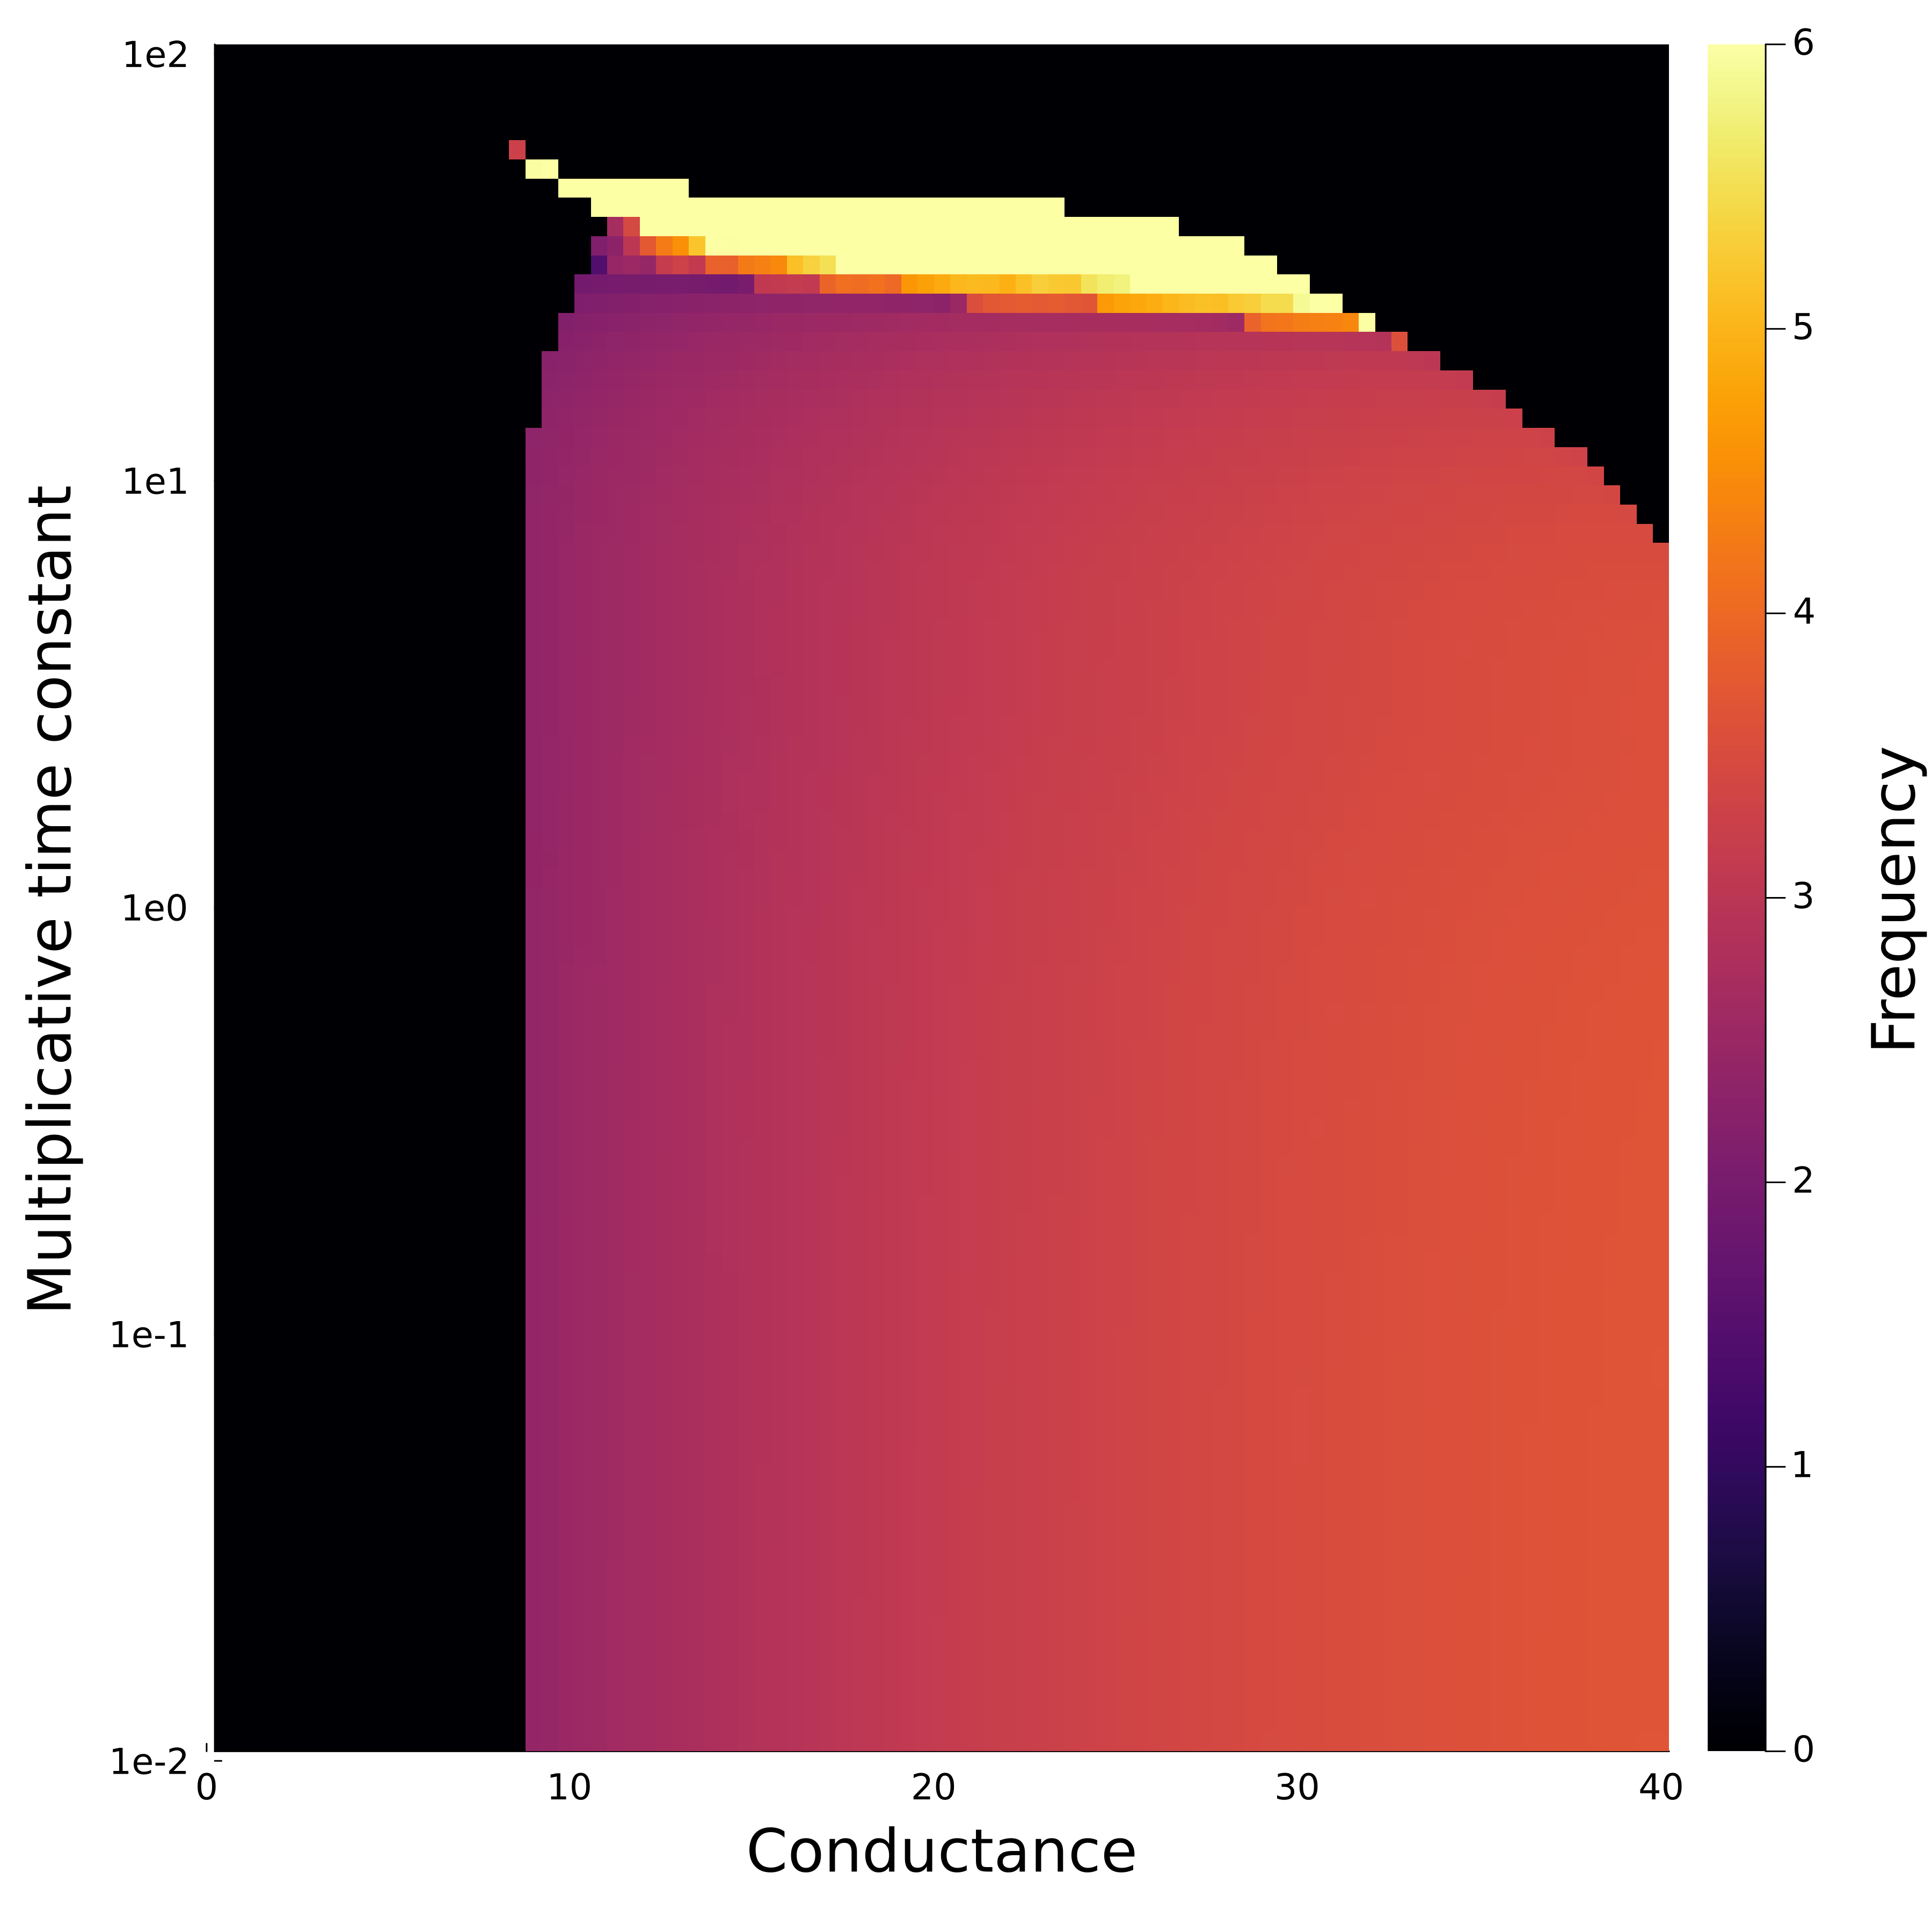

In [10]:
freqs_nonan = deepcopy(freqs)
freqs_nonan[isnan.(freqs)] .= 0
h = heatmap(freqs_nonan', 
    color=:inferno,              # Color scheme
    #title="Frequency Heatmap with Pacemaking Jehasse on Canavier",  # Title
    xlabel="Conductance", ylabel="Multiplicative time constant",  # Axis labels
    guidefontsize=25, tickfontsize=15, legendfontsize=25, titlefontsize=25, colorbar_titlefontsize=25,
    xticks=([0, 22.25, 44.5, 66.75, 89], ["0", "10", "20", "30", "40"]),     # Custom x-ticks
    yticks=([0, 22.25, 44.5, 66.75, 89], ["1e-2", "1e-1", "1e0", "1e1", "1e2"]),     # Custom y-ticks
    #aspect_ratio=:equal,          # Ensure square cells
    size=(1200, 1200),              # Size of the plot
    clims=(0, 6),
    dpi=300,
    colorbar_title="Frequency"   # Color bar label
)
# savefig(h, "./figures/fig4_heatmap_degenerate1.png")
# savefig(h, "./figures/fig4_heatmap_degenerate1.pdf")
# savefig(h, "./figures/fig4_heatmap_degenerate1.svg")

## Map 2

In [11]:
(gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, _) = g_all_pacemaker[is[2], :]

# Screening parameters
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
freqs = zeros(n, n)

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), mPacemaker_inf(V0), Ca0]

freqs = zeros(n, n)

for (i, gPacemaker) in enumerate(gPacemakers)
    display(i)
    for (j, tau) in enumerate(taus)
        # Parameter vector for simulations
        p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker, tau)
        
        # Simulation
        prob = ODEProblem(DA_ODE_true_notinstant, x0, tspan, p) # Describing the problem
        sol_ij = solve(prob, Tsit5(); maxiters=1e9, callback=cb,
                       save_everystep=false,save_start=false,save_end=false)
        
        if length(sol_ij.t) < 10
            freqs[i, j] = NaN
            
            ISIs_ij = Float64[]
            filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
            writedlm(filename, ISIs_ij)
        else
            spike_times = sol_ij.t
            filter!(x -> x ≥ 5000, spike_times)
            
            if length(spike_times) < 2
                freqs[i, j] = NaN
            
                ISIs_ij = Float64[]
                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)
            else
        
                # Extracting ISIs
                ISIs_ij = zeros(length(spike_times)-1)
                for k = 1 : length(spike_times) - 1
                    ISIs_ij[k] = spike_times[k+1] - spike_times[k]
                end

                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)

                freqs[i, j] = 1000/mean(ISIs_ij)
            end
        end
    end
end

writedlm("./data/freqs_degenerate2.dat", freqs);

1

2

3

┌ Warning: At t=1265.4787664698995, dt was forced below floating point epsilon 2.2737367544323206e-13, and step error estimate = 8.638685297451465. Aborting. There is either an error in your model specification or the true solution is unstable (or the true solution can not be represented in the precision of Float64).
└ @ SciMLBase C:\Users\Administrateur\.julia\packages\SciMLBase\l0G2E\src\integrator_interface.jl:623


4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

In [12]:
freqs = readdlm("./data/freqs_degenerate2.dat");

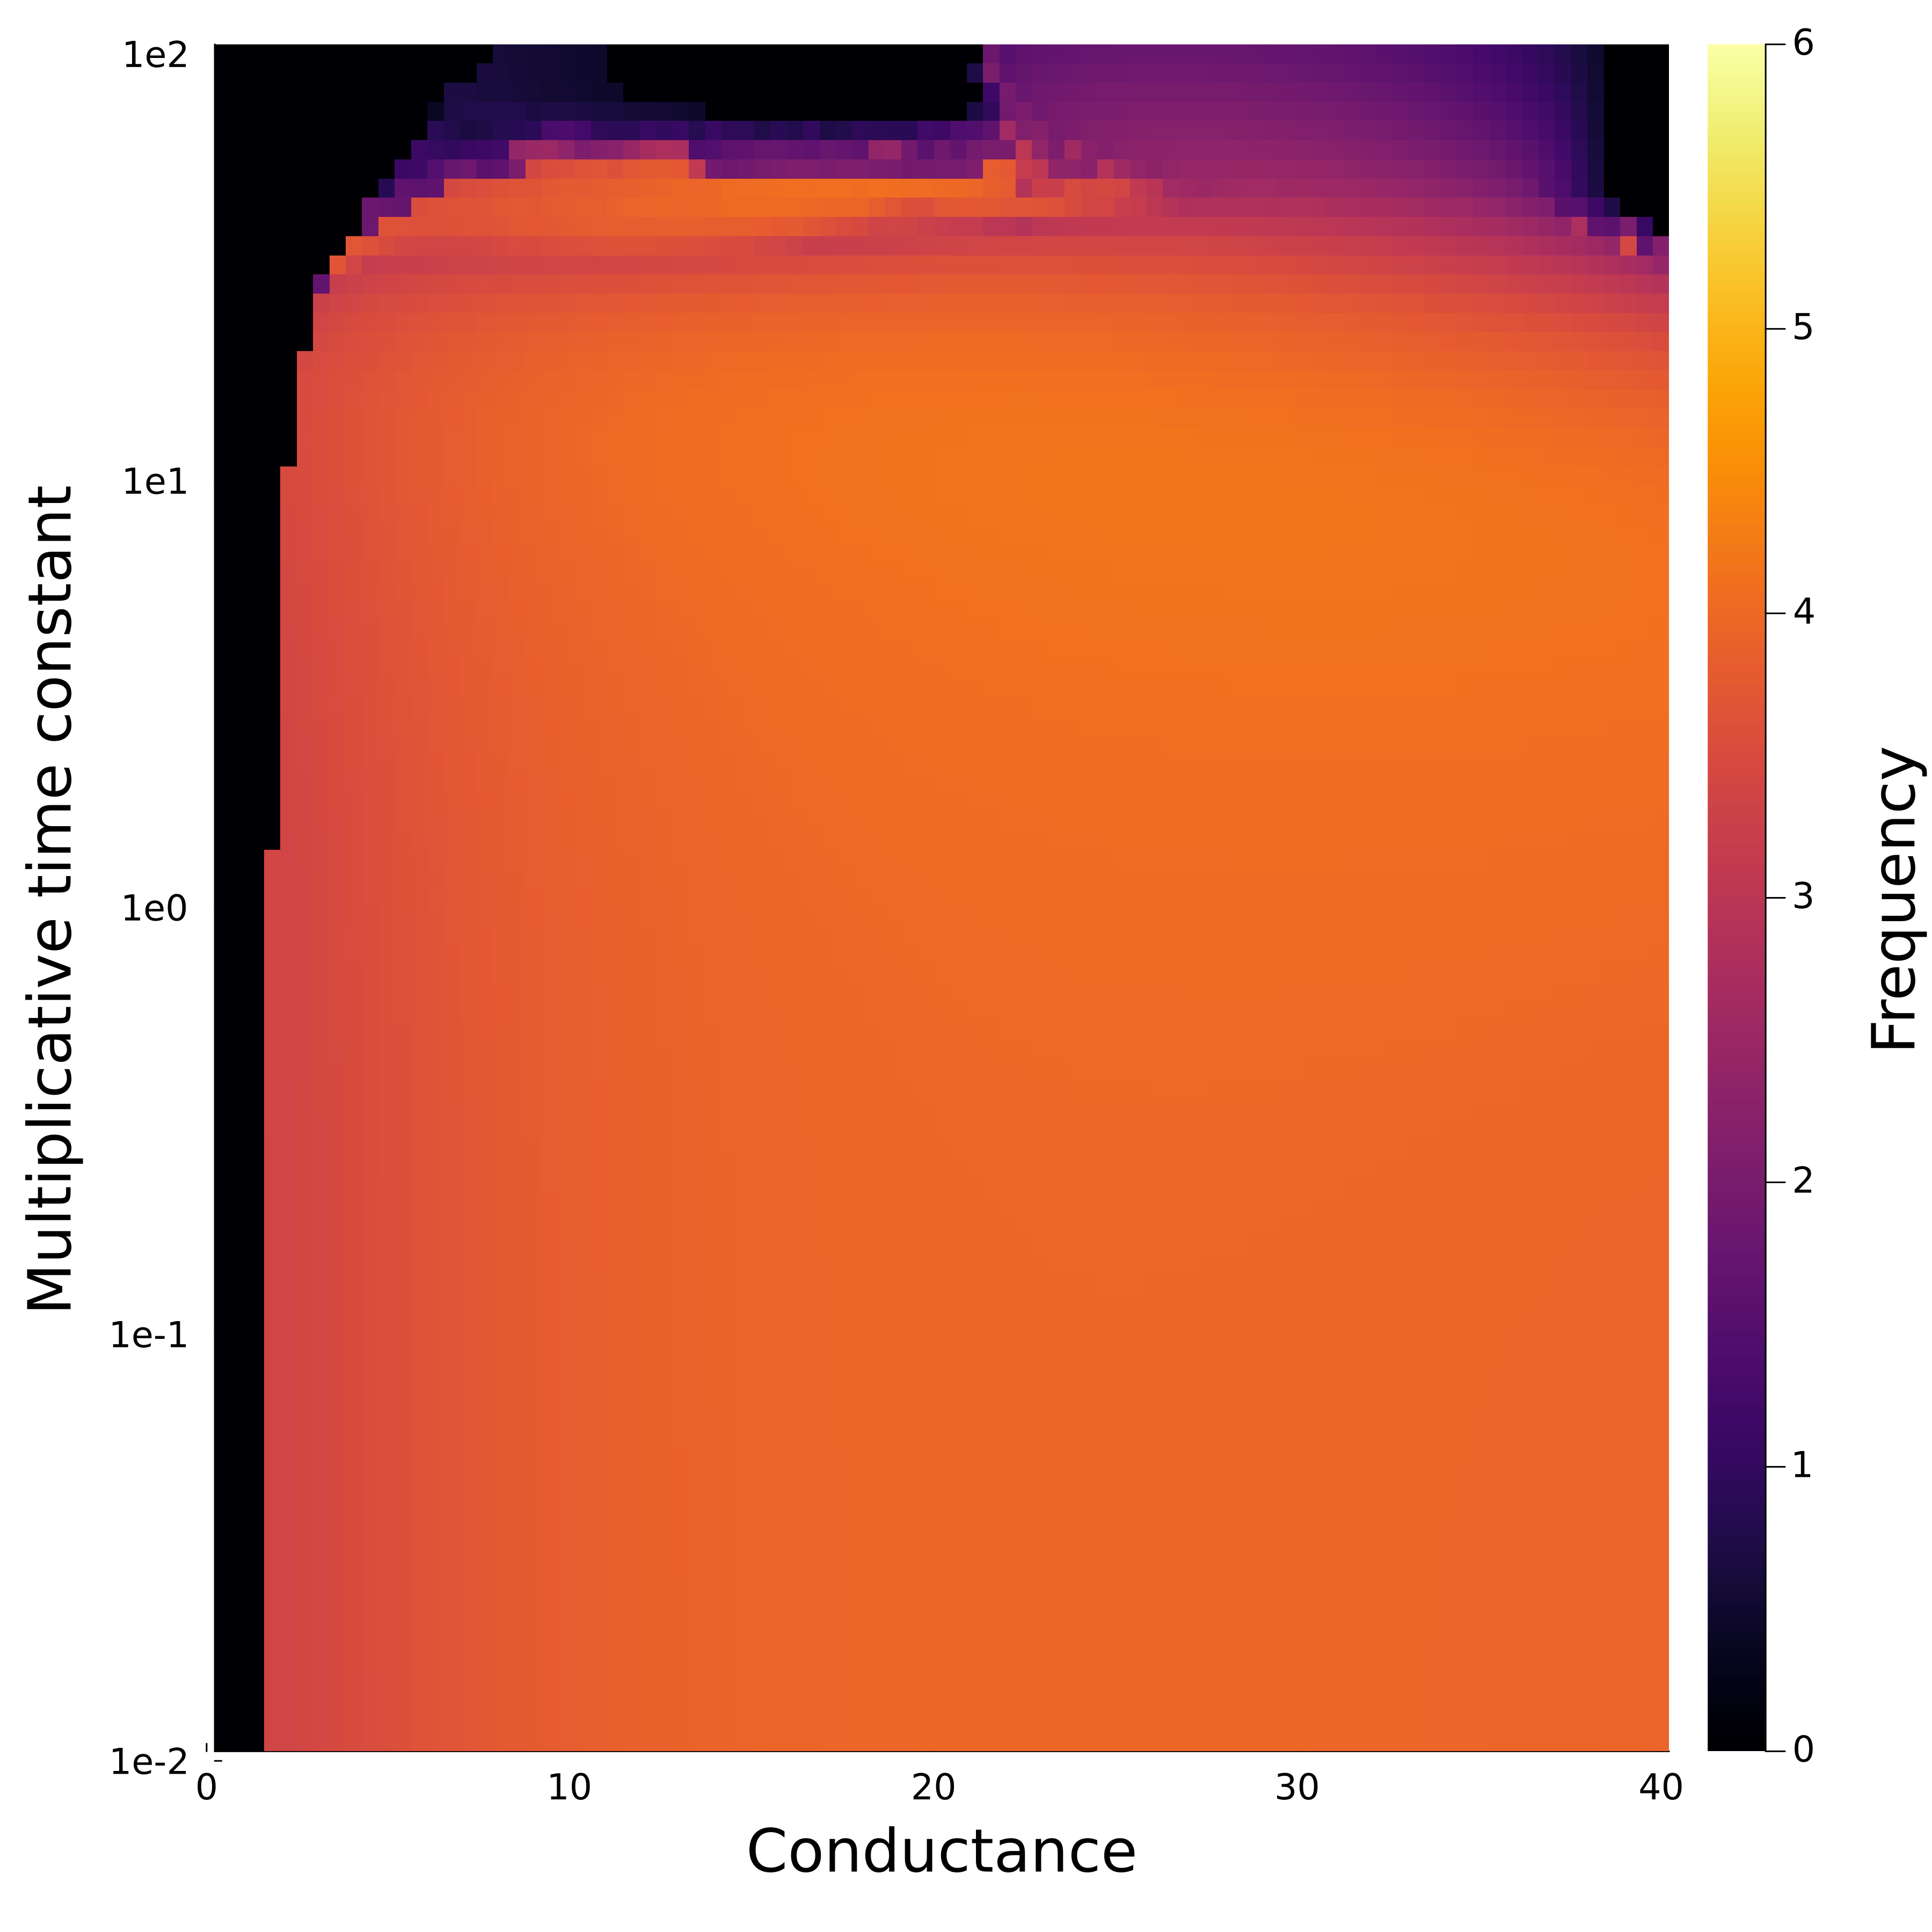

"C:\\Users\\Administrateur\\GitHub Desktop\\Pacemaking_Jehasse\\Canavier model\\figures\\fig4_heatmap_degenerate2.svg"

In [14]:
freqs_nonan = deepcopy(freqs)
freqs_nonan[isnan.(freqs)] .= 0
h = heatmap(freqs_nonan', 
    color=:inferno,              # Color scheme
    #title="Frequency Heatmap with Pacemaking Jehasse on Canavier",  # Title
    xlabel="Conductance", ylabel="Multiplicative time constant",  # Axis labels
    guidefontsize=25, tickfontsize=15, legendfontsize=25, titlefontsize=25, colorbar_titlefontsize=25,
    xticks=([0, 22.25, 44.5, 66.75, 89], ["0", "10", "20", "30", "40"]),     # Custom x-ticks
    yticks=([0, 22.25, 44.5, 66.75, 89], ["1e-2", "1e-1", "1e0", "1e1", "1e2"]),     # Custom y-ticks
    #aspect_ratio=:equal,          # Ensure square cells
    size=(1200, 1200),              # Size of the plot
    clims=(0, 6),
    dpi=300,
    colorbar_title="Frequency"   # Color bar label
)
display(h)
savefig(h, "./figures/fig4_heatmap_degenerate2.png")
savefig(h, "./figures/fig4_heatmap_degenerate2.pdf")
savefig(h, "./figures/fig4_heatmap_degenerate2.svg")

## Map 3

In [15]:
(gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, _) = g_all_pacemaker[is[3], :]

# Screening parameters
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
freqs = zeros(n, n)

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), mPacemaker_inf(V0), Ca0]

freqs = zeros(n, n)

for (i, gPacemaker) in enumerate(gPacemakers)
    display(i)
    for (j, tau) in enumerate(taus)
        # Parameter vector for simulations
        p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker, tau)
        
        # Simulation
        prob = ODEProblem(DA_ODE_true_notinstant, x0, tspan, p) # Describing the problem
        sol_ij = solve(prob, Tsit5(); maxiters=1e9, callback=cb,
                       save_everystep=false,save_start=false,save_end=false)
        
        if length(sol_ij.t) < 10
            freqs[i, j] = NaN
            
            ISIs_ij = Float64[]
            filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
            writedlm(filename, ISIs_ij)
        else
            spike_times = sol_ij.t
            filter!(x -> x ≥ 5000, spike_times)
            
            if length(spike_times) < 2
                freqs[i, j] = NaN
            
                ISIs_ij = Float64[]
                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)
            else
        
                # Extracting ISIs
                ISIs_ij = zeros(length(spike_times)-1)
                for k = 1 : length(spike_times) - 1
                    ISIs_ij[k] = spike_times[k+1] - spike_times[k]
                end

                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)

                freqs[i, j] = 1000/mean(ISIs_ij)
            end
        end
    end
end

writedlm("./data/freqs_degenerate3.dat", freqs);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

In [16]:
freqs = readdlm("./data/freqs_degenerate3.dat");

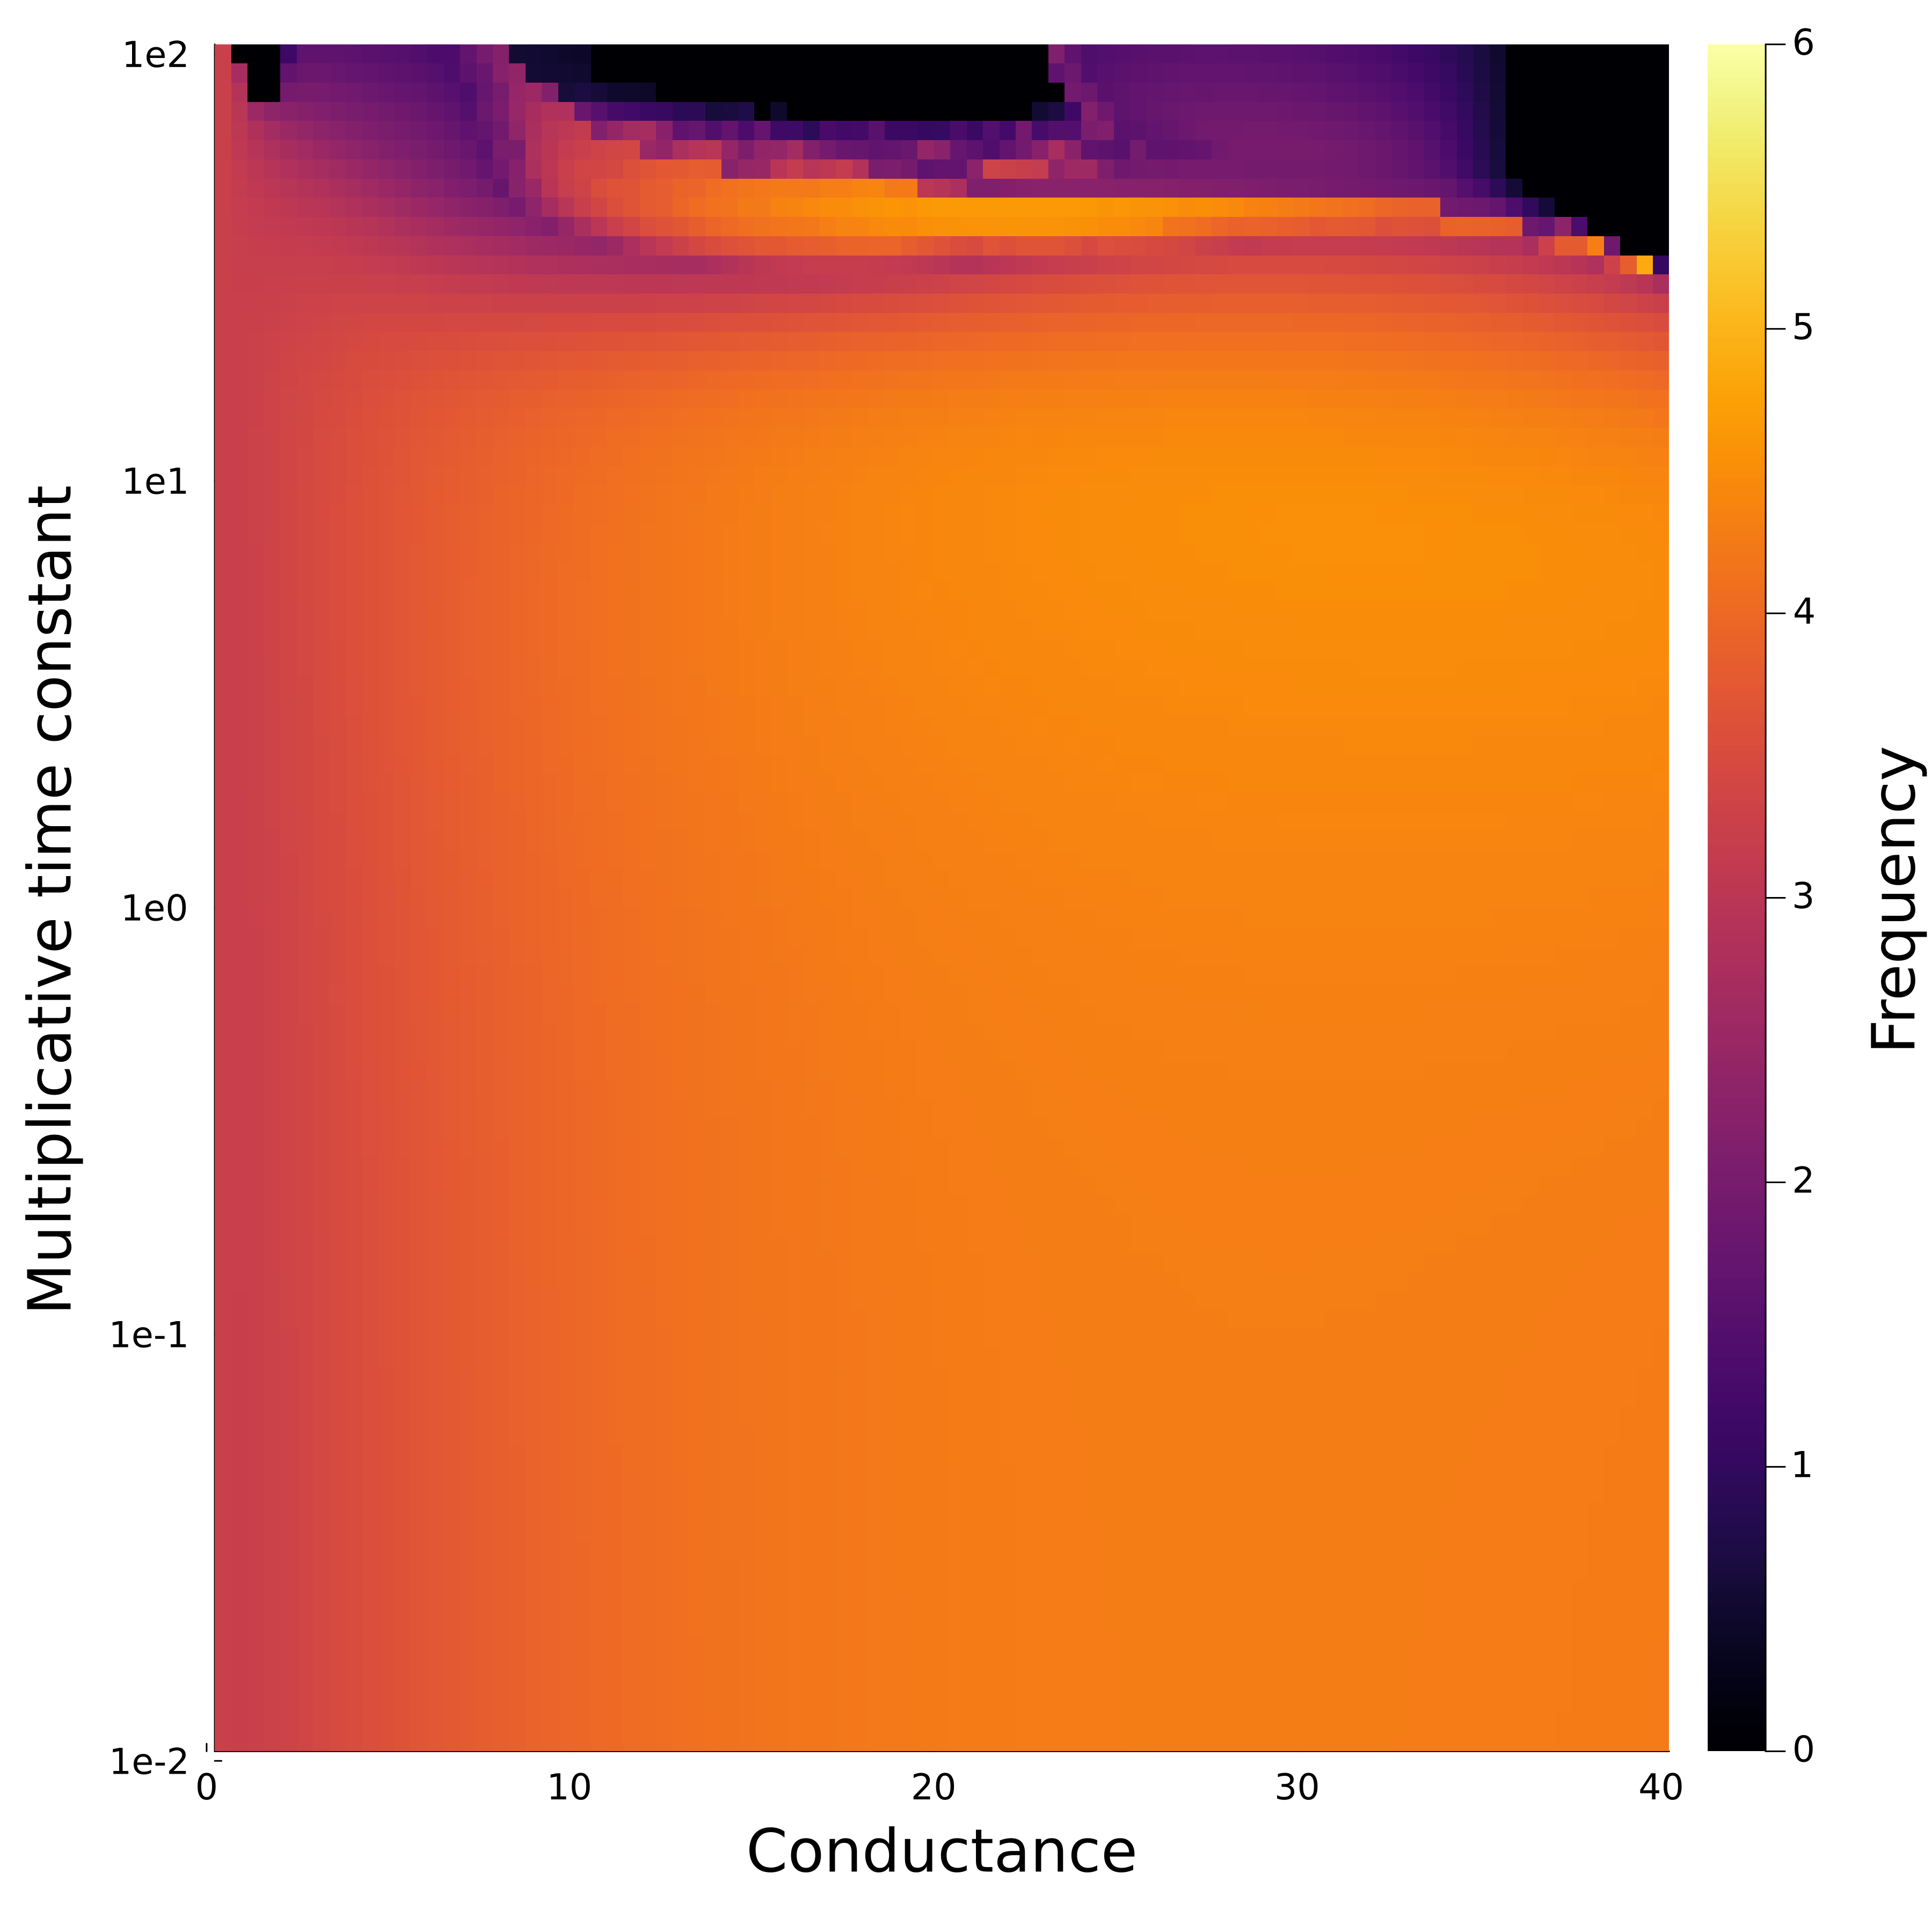

"C:\\Users\\Administrateur\\GitHub Desktop\\Pacemaking_Jehasse\\Canavier model\\figures\\fig4_heatmap_degenerate3.svg"

In [17]:
freqs_nonan = deepcopy(freqs)
freqs_nonan[isnan.(freqs)] .= 0
h = heatmap(freqs_nonan', 
    color=:inferno,              # Color scheme
    #title="Frequency Heatmap with Pacemaking Jehasse on Canavier",  # Title
    xlabel="Conductance", ylabel="Multiplicative time constant",  # Axis labels
    guidefontsize=25, tickfontsize=15, legendfontsize=25, titlefontsize=25, colorbar_titlefontsize=25,
    xticks=([0, 22.25, 44.5, 66.75, 89], ["0", "10", "20", "30", "40"]),     # Custom x-ticks
    yticks=([0, 22.25, 44.5, 66.75, 89], ["1e-2", "1e-1", "1e0", "1e1", "1e2"]),     # Custom y-ticks
    #aspect_ratio=:equal,          # Ensure square cells
    size=(1200, 1200),              # Size of the plot
    clims=(0, 6),
    dpi=300,
    colorbar_title="Frequency"   # Color bar label
)
display(h)
savefig(h, "./figures/fig4_heatmap_degenerate3.png")
savefig(h, "./figures/fig4_heatmap_degenerate3.pdf")
savefig(h, "./figures/fig4_heatmap_degenerate3.svg")

## Map 4

In [18]:
(gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, _) = g_all_pacemaker[is[4], :]

# Screening parameters
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
freqs = zeros(n, n)

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), mPacemaker_inf(V0), Ca0]

freqs = zeros(n, n)

for (i, gPacemaker) in enumerate(gPacemakers)
    display(i)
    for (j, tau) in enumerate(taus)
        # Parameter vector for simulations
        p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker, tau)
        
        # Simulation
        prob = ODEProblem(DA_ODE_true_notinstant, x0, tspan, p) # Describing the problem
        sol_ij = solve(prob, Tsit5(); maxiters=1e9, callback=cb,
                       save_everystep=false,save_start=false,save_end=false)
        
        if length(sol_ij.t) < 10
            freqs[i, j] = NaN
            
            ISIs_ij = Float64[]
            filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
            writedlm(filename, ISIs_ij)
        else
            spike_times = sol_ij.t
            filter!(x -> x ≥ 5000, spike_times)
            
            if length(spike_times) < 2
                freqs[i, j] = NaN
            
                ISIs_ij = Float64[]
                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)
            else
        
                # Extracting ISIs
                ISIs_ij = zeros(length(spike_times)-1)
                for k = 1 : length(spike_times) - 1
                    ISIs_ij[k] = spike_times[k+1] - spike_times[k]
                end

                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)

                freqs[i, j] = 1000/mean(ISIs_ij)
            end
        end
    end
end

writedlm("./data/freqs_degenerate4.dat", freqs);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

In [19]:
freqs = readdlm("./data/freqs_degenerate4.dat");

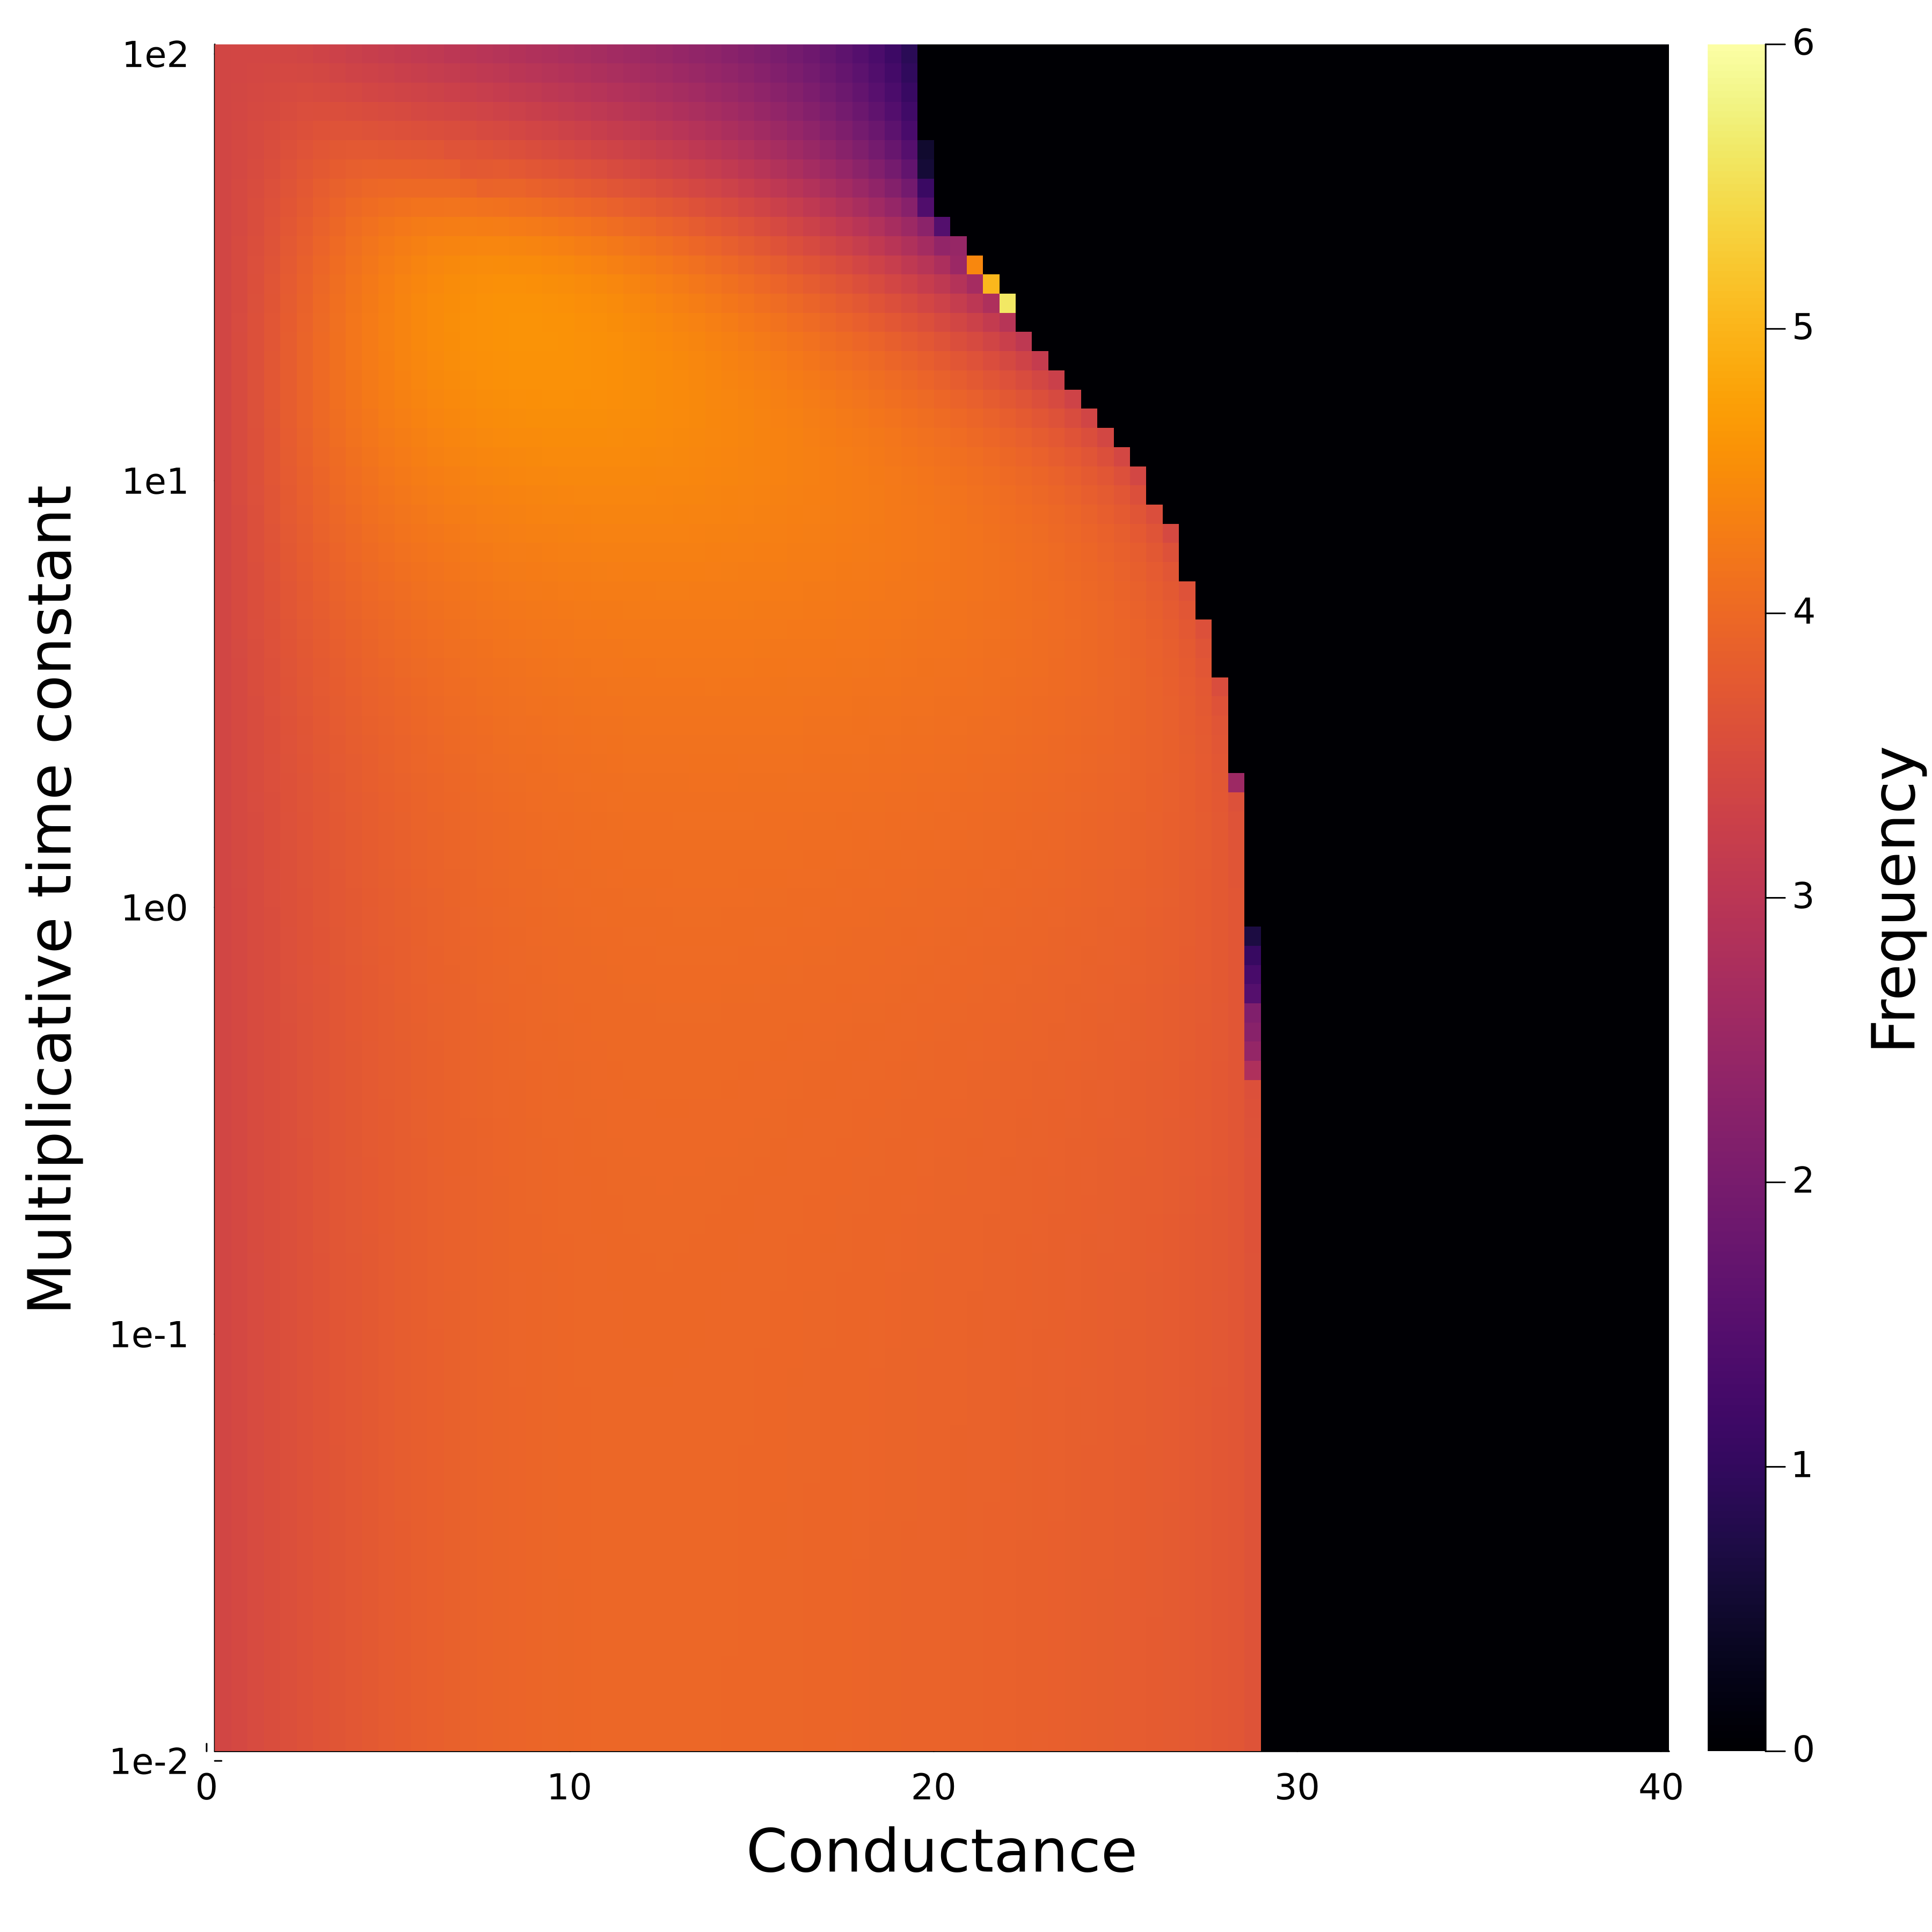

"C:\\Users\\Administrateur\\GitHub Desktop\\Pacemaking_Jehasse\\Canavier model\\figures\\fig4_heatmap_degenerate4.svg"

In [20]:
freqs_nonan = deepcopy(freqs)
freqs_nonan[isnan.(freqs)] .= 0
h = heatmap(freqs_nonan', 
    color=:inferno,              # Color scheme
    #title="Frequency Heatmap with Pacemaking Jehasse on Canavier",  # Title
    xlabel="Conductance", ylabel="Multiplicative time constant",  # Axis labels
    guidefontsize=25, tickfontsize=15, legendfontsize=25, titlefontsize=25, colorbar_titlefontsize=25,
    xticks=([0, 22.25, 44.5, 66.75, 89], ["0", "10", "20", "30", "40"]),     # Custom x-ticks
    yticks=([0, 22.25, 44.5, 66.75, 89], ["1e-2", "1e-1", "1e0", "1e1", "1e2"]),     # Custom y-ticks
    #aspect_ratio=:equal,          # Ensure square cells
    size=(1200, 1200),              # Size of the plot
    clims=(0, 6),
    dpi=300,
    colorbar_title="Frequency"   # Color bar label
)
display(h)
savefig(h, "./figures/fig4_heatmap_degenerate4.png")
savefig(h, "./figures/fig4_heatmap_degenerate4.pdf")
savefig(h, "./figures/fig4_heatmap_degenerate4.svg")

## Map 5

In [6]:
(gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, _) = g_all_pacemaker[is[5], :]

# Screening parameters
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
freqs = zeros(n, n)

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), mPacemaker_inf(V0), Ca0]

freqs = zeros(n, n)

for (i, gPacemaker) in enumerate(gPacemakers)
    display(i)
    for (j, tau) in enumerate(taus)
        # Parameter vector for simulations
        p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker, tau)
        
        # Simulation
        prob = ODEProblem(DA_ODE_true_notinstant, x0, tspan, p) # Describing the problem
        sol_ij = solve(prob, Tsit5(); maxiters=1e9, callback=cb,
                       save_everystep=false,save_start=false,save_end=false)
        
        if length(sol_ij.t) < 10
            freqs[i, j] = NaN
            
            ISIs_ij = Float64[]
            filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
            writedlm(filename, ISIs_ij)
        else
            spike_times = sol_ij.t
            filter!(x -> x ≥ 5000, spike_times)
            
            if length(spike_times) < 2
                freqs[i, j] = NaN
            
                ISIs_ij = Float64[]
                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)
            else
        
                # Extracting ISIs
                ISIs_ij = zeros(length(spike_times)-1)
                for k = 1 : length(spike_times) - 1
                    ISIs_ij[k] = spike_times[k+1] - spike_times[k]
                end

                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)

                freqs[i, j] = 1000/mean(ISIs_ij)
            end
        end
    end
end

writedlm("./data/freqs_degenerate5.dat", freqs);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

In [7]:
freqs = readdlm("./data/freqs_degenerate5.dat");

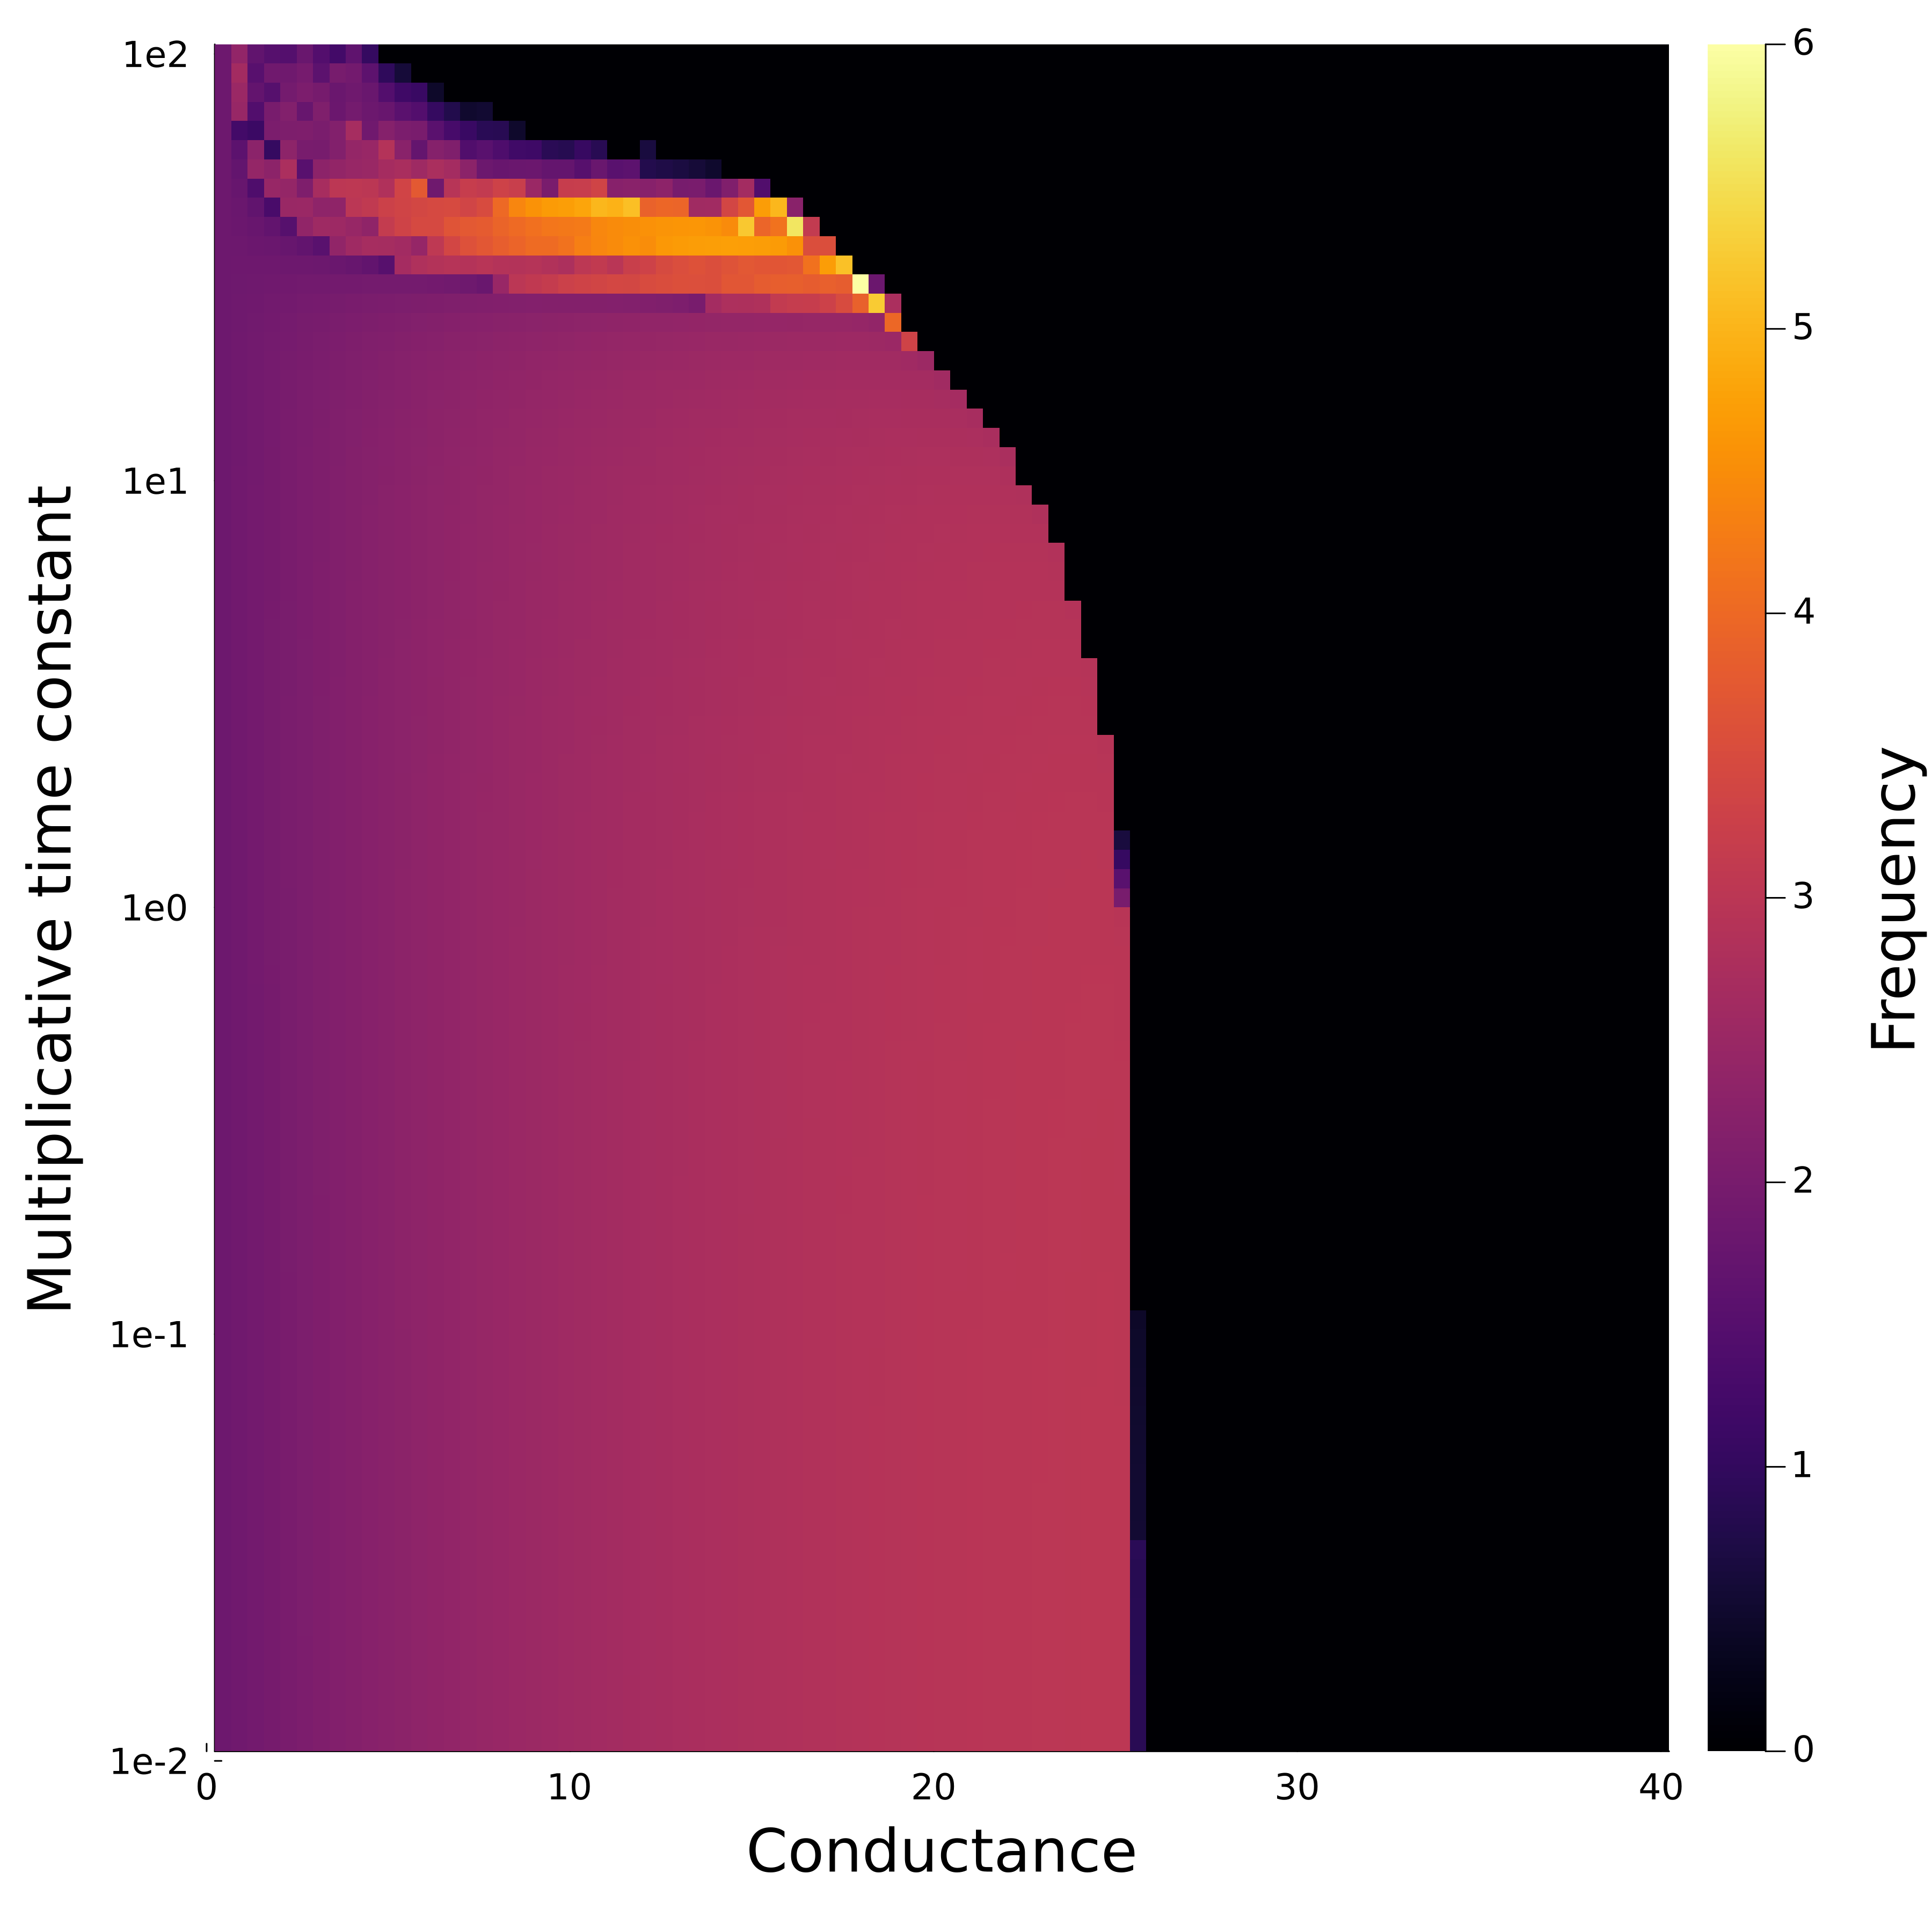

"C:\\Users\\Administrateur\\GitHub Desktop\\Pacemaking_Jehasse\\Canavier model\\figures\\fig4_heatmap_degenerate5.svg"

In [8]:
freqs_nonan = deepcopy(freqs)
freqs_nonan[isnan.(freqs)] .= 0
h = heatmap(freqs_nonan', 
    color=:inferno,              # Color scheme
    #title="Frequency Heatmap with Pacemaking Jehasse on Canavier",  # Title
    xlabel="Conductance", ylabel="Multiplicative time constant",  # Axis labels
    guidefontsize=25, tickfontsize=15, legendfontsize=25, titlefontsize=25, colorbar_titlefontsize=25,
    xticks=([0, 22.25, 44.5, 66.75, 89], ["0", "10", "20", "30", "40"]),     # Custom x-ticks
    yticks=([0, 22.25, 44.5, 66.75, 89], ["1e-2", "1e-1", "1e0", "1e1", "1e2"]),     # Custom y-ticks
    #aspect_ratio=:equal,          # Ensure square cells
    size=(1200, 1200),              # Size of the plot
    clims=(0, 6),
    dpi=300,
    colorbar_title="Frequency"   # Color bar label
)
display(h)
savefig(h, "./figures/fig4_heatmap_degenerate5.png")
savefig(h, "./figures/fig4_heatmap_degenerate5.pdf")
savefig(h, "./figures/fig4_heatmap_degenerate5.svg")

## Map 6

In [6]:
(gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, _) = g_all_pacemaker[145, :]

# Screening parameters
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
freqs = zeros(n, n)

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), mPacemaker_inf(V0), Ca0]

freqs = zeros(n, n)

for (i, gPacemaker) in enumerate(gPacemakers)
    display(i)
    for (j, tau) in enumerate(taus)
        # Parameter vector for simulations
        p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker, tau)
        
        # Simulation
        prob = ODEProblem(DA_ODE_true_notinstant, x0, tspan, p) # Describing the problem
        sol_ij = solve(prob, Tsit5(), maxtime=30.0; maxiters=1e9, callback=cb,
                       save_everystep=false,save_start=false,save_end=false)
        
        if length(sol_ij.t) < 10
            freqs[i, j] = NaN
            
            ISIs_ij = Float64[]
            filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
            writedlm(filename, ISIs_ij)
        else
            spike_times = sol_ij.t
            filter!(x -> x ≥ 5000, spike_times)
            
            if length(spike_times) < 2
                freqs[i, j] = NaN
            
                ISIs_ij = Float64[]
                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)
            else
        
                # Extracting ISIs
                ISIs_ij = zeros(length(spike_times)-1)
                for k = 1 : length(spike_times) - 1
                    ISIs_ij[k] = spike_times[k+1] - spike_times[k]
                end

                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)

                freqs[i, j] = 1000/mean(ISIs_ij)
            end
        end
    end
end

writedlm("./data/freqs_degenerate6.dat", freqs);

1

2

3

4

5

6

7

8

9

10

11

12

13

14

15

16

17

18

19

20

21

22

23

24

25

26

27

28

29

30

31

32

33

34

35

36

37

38

39

40

41

42

43

44

45

46

47

48

49

50

51

52

53

54

55

56

57

58

59

60

61

62

63

64

65

66

67

68

69

70

71

72

73

74

75

76

77

78

79

80

81

82

83

84

85

86

87

88

89

In [7]:
freqs = readdlm("./data/freqs_degenerate6.dat");

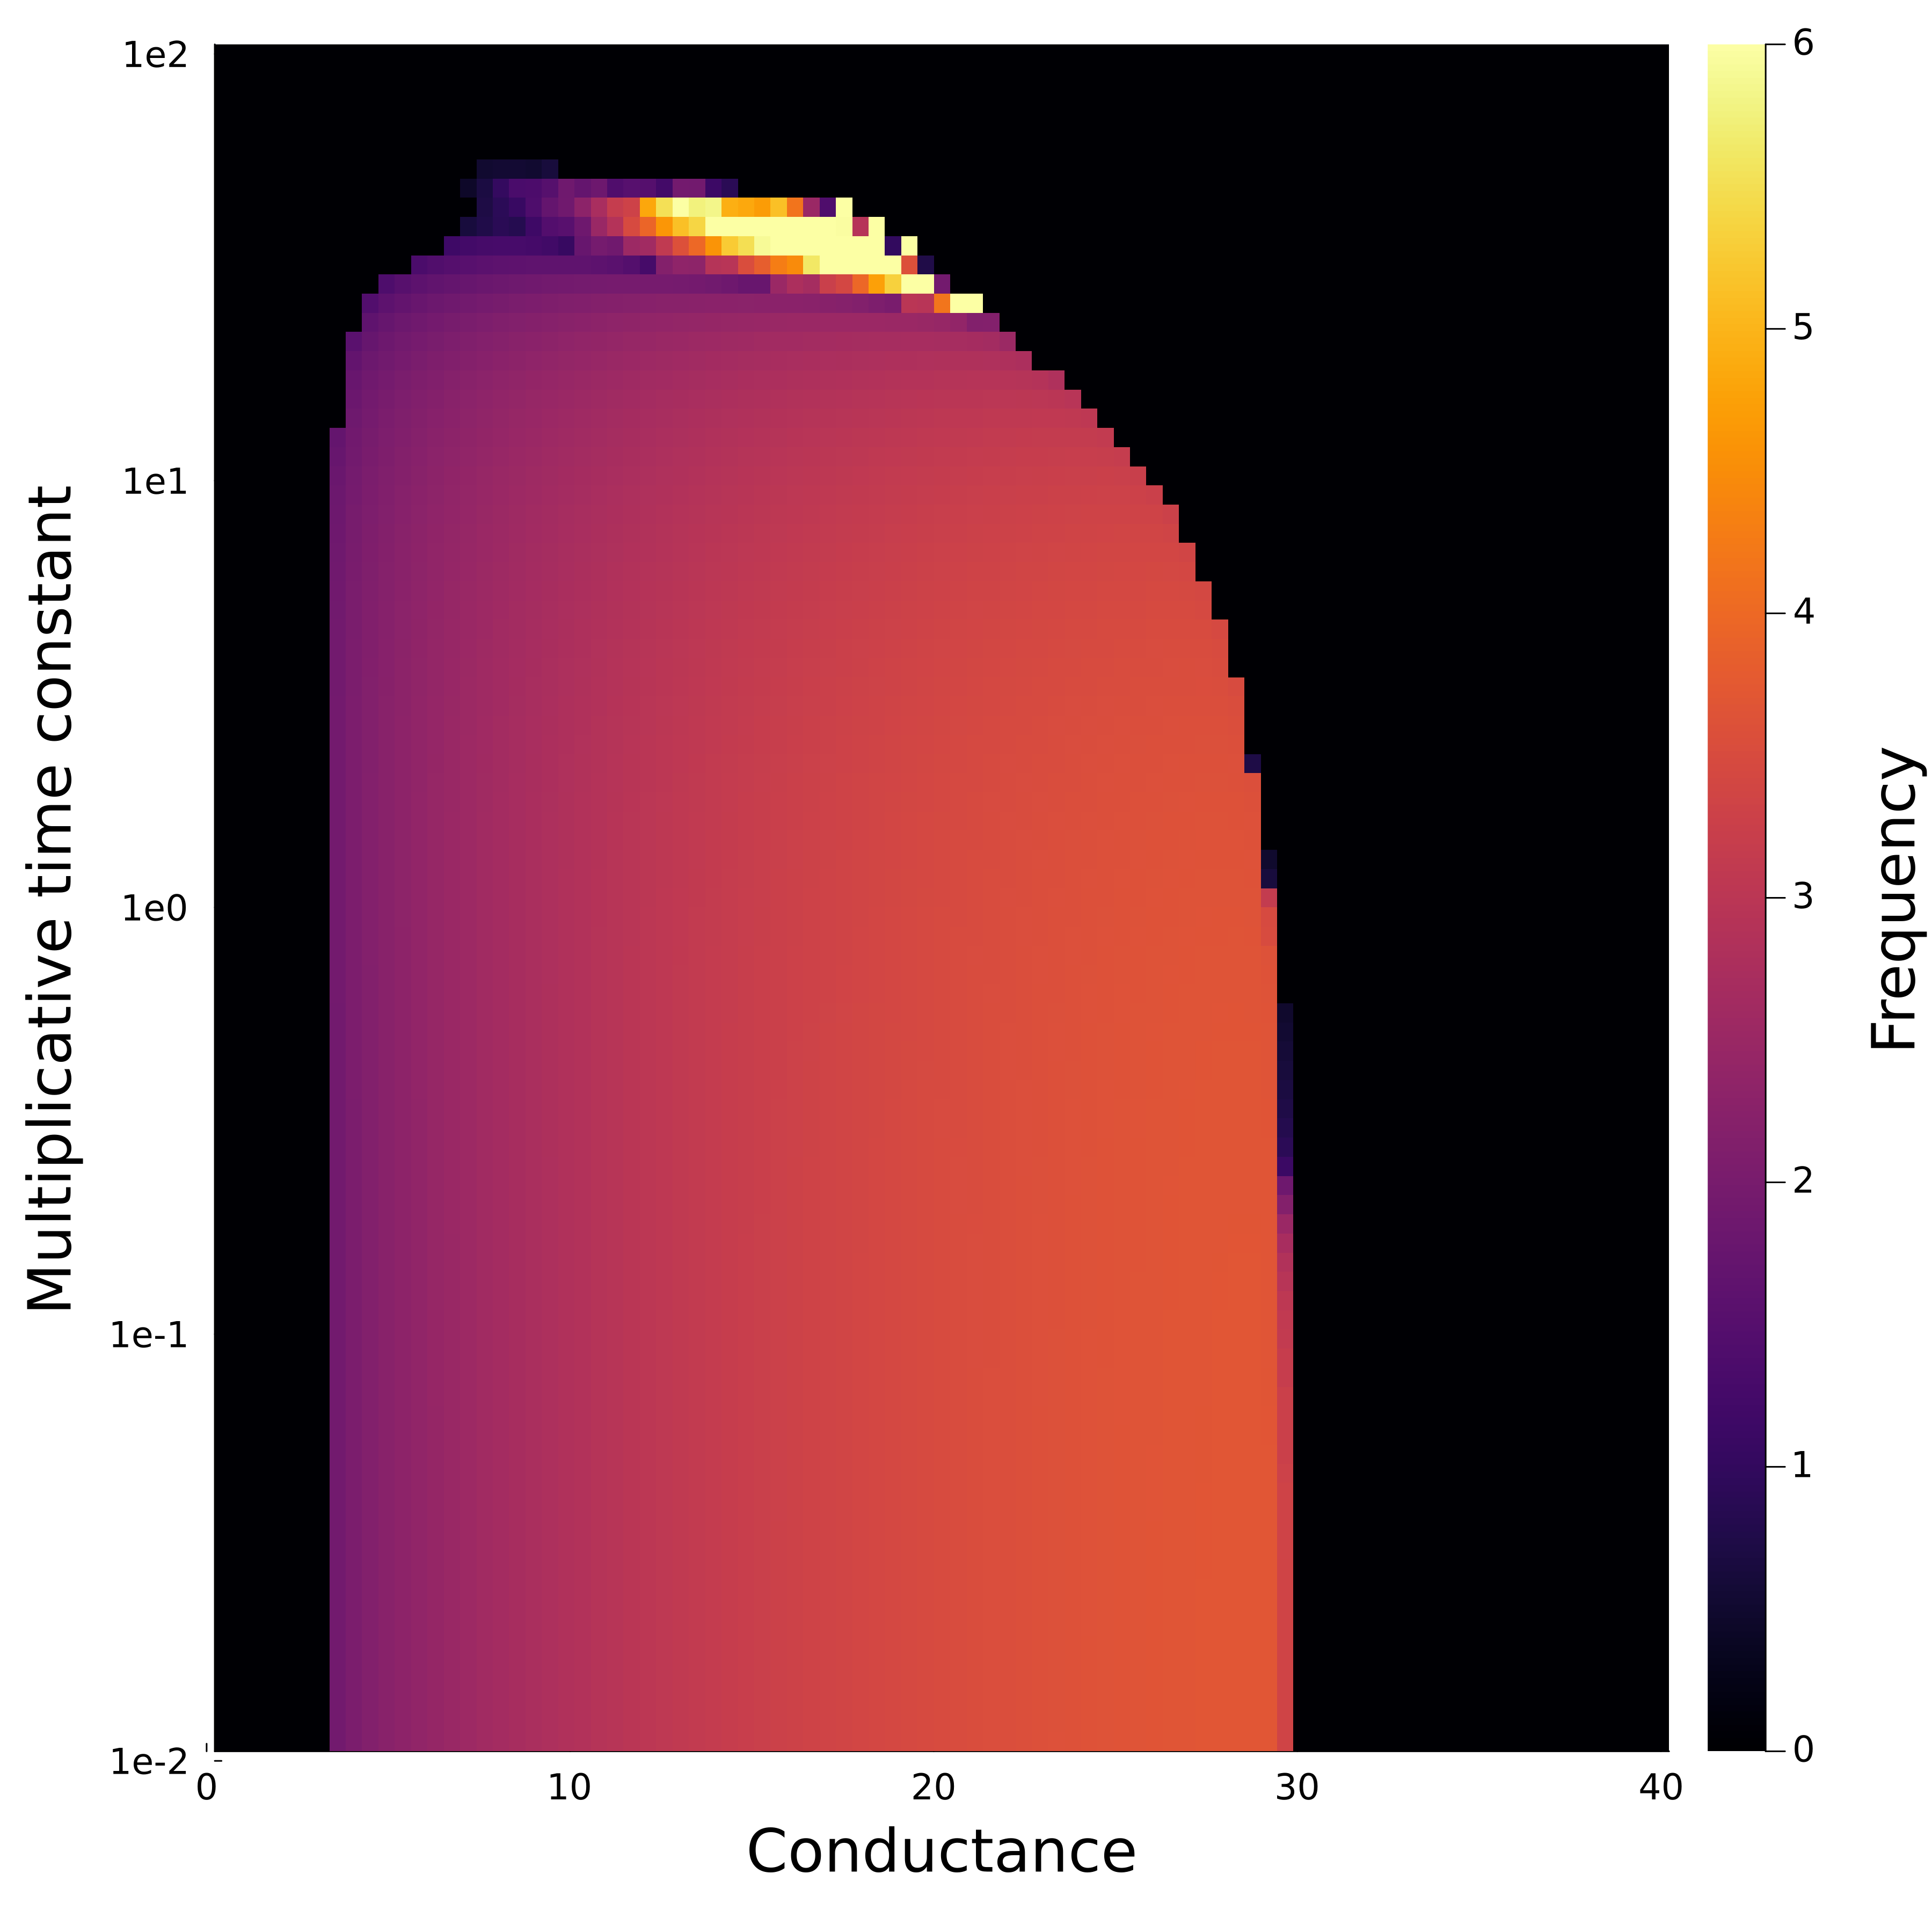

"C:\\Users\\Administrateur\\GitHub Desktop\\Pacemaking_Jehasse\\Canavier model\\figures\\fig4_heatmap_degenerate6.svg"

In [8]:
freqs_nonan = deepcopy(freqs)
freqs_nonan[isnan.(freqs)] .= 0
h = heatmap(freqs_nonan', 
    color=:inferno,              # Color scheme
    #title="Frequency Heatmap with Pacemaking Jehasse on Canavier",  # Title
    xlabel="Conductance", ylabel="Multiplicative time constant",  # Axis labels
    guidefontsize=25, tickfontsize=15, legendfontsize=25, titlefontsize=25, colorbar_titlefontsize=25,
    xticks=([0, 22.25, 44.5, 66.75, 89], ["0", "10", "20", "30", "40"]),     # Custom x-ticks
    yticks=([0, 22.25, 44.5, 66.75, 89], ["1e-2", "1e-1", "1e0", "1e1", "1e2"]),     # Custom y-ticks
    #aspect_ratio=:equal,          # Ensure square cells
    size=(1200, 1200),              # Size of the plot
    clims=(0, 6),
    dpi=300,
    colorbar_title="Frequency"   # Color bar label
)
display(h)
savefig(h, "./figures/fig4_heatmap_degenerate6.png")
savefig(h, "./figures/fig4_heatmap_degenerate6.pdf")
savefig(h, "./figures/fig4_heatmap_degenerate6.svg")

## Map 7

In [ ]:
(gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, _) = g_all_pacemaker[is[7], :]

# Screening parameters
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
freqs = zeros(n, n)

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), mPacemaker_inf(V0), Ca0]

freqs = zeros(n, n)

for (i, gPacemaker) in enumerate(gPacemakers)
    display(i)
    for (j, tau) in enumerate(taus)
        # Parameter vector for simulations
        p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker, tau)
        
        # Simulation
        prob = ODEProblem(DA_ODE_true_notinstant, x0, tspan, p) # Describing the problem
        sol_ij = solve(prob, Tsit5(); maxiters=1e9, callback=cb,
                       save_everystep=false,save_start=false,save_end=false)
        
        if length(sol_ij.t) < 10
            freqs[i, j] = NaN
            
            ISIs_ij = Float64[]
            filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
            writedlm(filename, ISIs_ij)
        else
            spike_times = sol_ij.t
            filter!(x -> x ≥ 5000, spike_times)
            
            if length(spike_times) < 2
                freqs[i, j] = NaN
            
                ISIs_ij = Float64[]
                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)
            else
        
                # Extracting ISIs
                ISIs_ij = zeros(length(spike_times)-1)
                for k = 1 : length(spike_times) - 1
                    ISIs_ij[k] = spike_times[k+1] - spike_times[k]
                end

                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)

                freqs[i, j] = 1000/mean(ISIs_ij)
            end
        end
    end
end

writedlm("./data/freqs_degenerate7.dat", freqs);

In [ ]:
freqs = readdlm("./data/freqs_degenerate7.dat");

In [ ]:
freqs_nonan = deepcopy(freqs)
freqs_nonan[isnan.(freqs)] .= 0
h = heatmap(freqs_nonan', 
    color=:inferno,              # Color scheme
    #title="Frequency Heatmap with Pacemaking Jehasse on Canavier",  # Title
    xlabel="Conductance", ylabel="Multiplicative time constant",  # Axis labels
    guidefontsize=25, tickfontsize=15, legendfontsize=25, titlefontsize=25, colorbar_titlefontsize=25,
    xticks=([0, 22.25, 44.5, 66.75, 89], ["0", "10", "20", "30", "40"]),     # Custom x-ticks
    yticks=([0, 22.25, 44.5, 66.75, 89], ["1e-2", "1e-1", "1e0", "1e1", "1e2"]),     # Custom y-ticks
    #aspect_ratio=:equal,          # Ensure square cells
    size=(1200, 1200),              # Size of the plot
    clims=(0, 6),
    dpi=300,
    colorbar_title="Frequency"   # Color bar label
)
display(h)
savefig(h, "./figures/fig4_heatmap_degenerate7.png")
savefig(h, "./figures/fig4_heatmap_degenerate7.pdf")
savefig(h, "./figures/fig4_heatmap_degenerate7.svg")

## Map 8

In [ ]:
(gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, _) = g_all_pacemaker[is[8], :]

# Screening parameters
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
freqs = zeros(n, n)

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), mPacemaker_inf(V0), Ca0]

freqs = zeros(n, n)

for (i, gPacemaker) in enumerate(gPacemakers)
    display(i)
    for (j, tau) in enumerate(taus)
        # Parameter vector for simulations
        p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker, tau)
        
        # Simulation
        prob = ODEProblem(DA_ODE_true_notinstant, x0, tspan, p) # Describing the problem
        sol_ij = solve(prob, Tsit5(); maxiters=1e9, callback=cb,
                       save_everystep=false,save_start=false,save_end=false)
        
        if length(sol_ij.t) < 10
            freqs[i, j] = NaN
            
            ISIs_ij = Float64[]
            filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
            writedlm(filename, ISIs_ij)
        else
            spike_times = sol_ij.t
            filter!(x -> x ≥ 5000, spike_times)
            
            if length(spike_times) < 2
                freqs[i, j] = NaN
            
                ISIs_ij = Float64[]
                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)
            else
        
                # Extracting ISIs
                ISIs_ij = zeros(length(spike_times)-1)
                for k = 1 : length(spike_times) - 1
                    ISIs_ij[k] = spike_times[k+1] - spike_times[k]
                end

                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)

                freqs[i, j] = 1000/mean(ISIs_ij)
            end
        end
    end
end

writedlm("./data/freqs_degenerate8.dat", freqs);

In [ ]:
freqs = readdlm("./data/freqs_degenerate8.dat");

In [ ]:
freqs_nonan = deepcopy(freqs)
freqs_nonan[isnan.(freqs)] .= 0
h = heatmap(freqs_nonan', 
    color=:inferno,              # Color scheme
    #title="Frequency Heatmap with Pacemaking Jehasse on Canavier",  # Title
    xlabel="Conductance", ylabel="Multiplicative time constant",  # Axis labels
    guidefontsize=25, tickfontsize=15, legendfontsize=25, titlefontsize=25, colorbar_titlefontsize=25,
    xticks=([0, 22.25, 44.5, 66.75, 89], ["0", "10", "20", "30", "40"]),     # Custom x-ticks
    yticks=([0, 22.25, 44.5, 66.75, 89], ["1e-2", "1e-1", "1e0", "1e1", "1e2"]),     # Custom y-ticks
    #aspect_ratio=:equal,          # Ensure square cells
    size=(1200, 1200),              # Size of the plot
    clims=(0, 6),
    dpi=300,
    colorbar_title="Frequency"   # Color bar label
)
display(h)
savefig(h, "./figures/fig4_heatmap_degenerate8.png")
savefig(h, "./figures/fig4_heatmap_degenerate8.pdf")
savefig(h, "./figures/fig4_heatmap_degenerate8.svg")

## Map 9

In [ ]:
(gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, _) = g_all_pacemaker[is[9], :]

# Screening parameters
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
freqs = zeros(n, n)

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), mPacemaker_inf(V0), Ca0]

freqs = zeros(n, n)

for (i, gPacemaker) in enumerate(gPacemakers)
    display(i)
    for (j, tau) in enumerate(taus)
        # Parameter vector for simulations
        p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker, tau)
        
        # Simulation
        prob = ODEProblem(DA_ODE_true_notinstant, x0, tspan, p) # Describing the problem
        sol_ij = solve(prob, Tsit5(); maxiters=1e9, callback=cb,
                       save_everystep=false,save_start=false,save_end=false)
        
        if length(sol_ij.t) < 10
            freqs[i, j] = NaN
            
            ISIs_ij = Float64[]
            filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
            writedlm(filename, ISIs_ij)
        else
            spike_times = sol_ij.t
            filter!(x -> x ≥ 5000, spike_times)
            
            if length(spike_times) < 2
                freqs[i, j] = NaN
            
                ISIs_ij = Float64[]
                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)
            else
        
                # Extracting ISIs
                ISIs_ij = zeros(length(spike_times)-1)
                for k = 1 : length(spike_times) - 1
                    ISIs_ij[k] = spike_times[k+1] - spike_times[k]
                end

                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)

                freqs[i, j] = 1000/mean(ISIs_ij)
            end
        end
    end
end

writedlm("./data/freqs_degenerate9.dat", freqs);

In [ ]:
freqs = readdlm("./data/freqs_degenerate9.dat");

In [ ]:
freqs_nonan = deepcopy(freqs)
freqs_nonan[isnan.(freqs)] .= 0
h = heatmap(freqs_nonan', 
    color=:inferno,              # Color scheme
    #title="Frequency Heatmap with Pacemaking Jehasse on Canavier",  # Title
    xlabel="Conductance", ylabel="Multiplicative time constant",  # Axis labels
    guidefontsize=25, tickfontsize=15, legendfontsize=25, titlefontsize=25, colorbar_titlefontsize=25,
    xticks=([0, 22.25, 44.5, 66.75, 89], ["0", "10", "20", "30", "40"]),     # Custom x-ticks
    yticks=([0, 22.25, 44.5, 66.75, 89], ["1e-2", "1e-1", "1e0", "1e1", "1e2"]),     # Custom y-ticks
    #aspect_ratio=:equal,          # Ensure square cells
    size=(1200, 1200),              # Size of the plot
    clims=(0, 6),
    dpi=300,
    colorbar_title="Frequency"   # Color bar label
)
display(h)
savefig(h, "./figures/fig4_heatmap_degenerate9.png")
savefig(h, "./figures/fig4_heatmap_degenerate9.pdf")
savefig(h, "./figures/fig4_heatmap_degenerate9.svg")

## Map 10

In [ ]:
(gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, _) = g_all_pacemaker[is[10], :]

# Screening parameters
n = 89
taus = 10 .^ range(-2, 2, length=n)
gPacemakers = range(0, 40, length=n)
freqs = zeros(n, n)

# Input current definition
Iapp(t) = 0 # pA

# Initial conditions
V0 = -50.
Ca0 = 1e-4
x0 = [V0, m_inf(V0), h_inf(V0), hs_inf(V0), l_inf(V0), n_inf(V0), p_inf(V0), q1_inf(V0), q2_inf(V0), 
    0., 0., mH_inf(V0), mPacemaker_inf(V0), Ca0]

freqs = zeros(n, n)

for (i, gPacemaker) in enumerate(gPacemakers)
    display(i)
    for (j, tau) in enumerate(taus)
        # Parameter vector for simulations
        p = (Iapp, gNa, gCaL, gKd, gKA, gKERG, gKSK, gH, gLNS, gLCa, gPacemaker, tau)
        
        # Simulation
        prob = ODEProblem(DA_ODE_true_notinstant, x0, tspan, p) # Describing the problem
        sol_ij = solve(prob, Tsit5(); maxiters=1e9, callback=cb,
                       save_everystep=false,save_start=false,save_end=false)
        
        if length(sol_ij.t) < 10
            freqs[i, j] = NaN
            
            ISIs_ij = Float64[]
            filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
            writedlm(filename, ISIs_ij)
        else
            spike_times = sol_ij.t
            filter!(x -> x ≥ 5000, spike_times)
            
            if length(spike_times) < 2
                freqs[i, j] = NaN
            
                ISIs_ij = Float64[]
                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)
            else
        
                # Extracting ISIs
                ISIs_ij = zeros(length(spike_times)-1)
                for k = 1 : length(spike_times) - 1
                    ISIs_ij[k] = spike_times[k+1] - spike_times[k]
                end

                filename = "./data/ISIs_nonoise_$(i)_$(j).dat"
                writedlm(filename, ISIs_ij)

                freqs[i, j] = 1000/mean(ISIs_ij)
            end
        end
    end
end

writedlm("./data/freqs_degenerate10.dat", freqs);

In [ ]:
freqs = readdlm("./data/freqs_degenerate10.dat");

In [ ]:
freqs_nonan = deepcopy(freqs)
freqs_nonan[isnan.(freqs)] .= 0
h = heatmap(freqs_nonan', 
    color=:inferno,              # Color scheme
    #title="Frequency Heatmap with Pacemaking Jehasse on Canavier",  # Title
    xlabel="Conductance", ylabel="Multiplicative time constant",  # Axis labels
    guidefontsize=25, tickfontsize=15, legendfontsize=25, titlefontsize=25, colorbar_titlefontsize=25,
    xticks=([0, 22.25, 44.5, 66.75, 89], ["0", "10", "20", "30", "40"]),     # Custom x-ticks
    yticks=([0, 22.25, 44.5, 66.75, 89], ["1e-2", "1e-1", "1e0", "1e1", "1e2"]),     # Custom y-ticks
    #aspect_ratio=:equal,          # Ensure square cells
    size=(1200, 1200),              # Size of the plot
    clims=(0, 6),
    dpi=300,
    colorbar_title="Frequency"   # Color bar label
)
display(h)
savefig(h, "./figures/fig4_heatmap_degenerate10.png")
savefig(h, "./figures/fig4_heatmap_degenerate10.pdf")
savefig(h, "./figures/fig4_heatmap_degenerate10.svg")